In [1]:
from math import trunc
from select import KQ_NOTE_WRITE

import polars as pl
import polars.selectors as cs

import altair as alt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
df_path = r'/Users/zygimantas/Downloads/computer_prices_all.csv'

In [3]:
df = pl.read_csv(df_path)

In [4]:
df.describe()

statistic,device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,cpu_threads,cpu_base_ghz,cpu_boost_ghz,gpu_brand,gpu_model,gpu_tier,vram_gb,ram_gb,storage_type,storage_gb,storage_drive_count,display_type,display_size_in,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price
str,str,str,str,f64,str,str,str,str,f64,f64,f64,f64,f64,str,str,f64,f64,f64,str,f64,f64,str,f64,str,f64,f64,f64,f64,str,f64,f64,f64,f64
"""count""","""100000""","""100000""","""100000""",100000.0,"""100000""","""100000""","""100000""","""100000""",100000.0,100000.0,100000.0,100000.0,100000.0,"""100000""","""100000""",100000.0,100000.0,100000.0,"""100000""",100000.0,100000.0,"""100000""",100000.0,"""100000""",100000.0,100000.0,100000.0,100000.0,"""100000""",100000.0,100000.0,100000.0,100000.0
"""null_count""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,"""0""",0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0
"""mean""",null,null,null,2022.32085,null,null,null,null,3.15349,10.51574,19.3727,2.591322,3.53131,null,null,2.99135,6.15218,39.7064,null,903.936,1.52498,null,20.126655,null,98.46486,41.81347,61.38345,272.5205,null,5.084764,4.2896992,22.20036,1928.76422
"""std""",null,null,null,2.025761,null,null,null,null,1.373175,5.044092,9.718426,0.336435,0.350024,null,null,1.459643,3.964926,31.902684,null,774.243654,0.797284,null,6.709577,null,43.301652,35.868841,62.795034,354.686355,null,0.245977,3.814628,10.2319,580.492689
"""min""","""Desktop""","""ASUS""","""ASUS Air 030""",2018.0,"""ChromeOS""","""2-in-1""","""AMD""","""AMD Ryzen 3 3102""",1.0,4.0,4.0,2.0,2.8,"""AMD""","""Apple Integrated""",1.0,0.0,8.0,"""HDD""",256.0,1.0,"""IPS""",13.3,"""1920x1080""",60.0,0.0,0.0,0.0,"""Wi-Fi 5""",4.2,0.92,12.0,372.99
"""25%""",null,null,null,2021.0,null,null,null,null,2.0,6.0,12.0,2.4,3.3,null,null,2.0,4.0,16.0,null,512.0,1.0,null,14.0,null,60.0,0.0,0.0,0.0,null,5.0,1.5,12.0,1503.99
"""50%""",null,null,null,2023.0,null,null,null,null,3.0,8.0,16.0,2.6,3.5,null,null,3.0,6.0,32.0,null,512.0,1.0,null,16.0,null,90.0,56.0,65.0,0.0,null,5.1,2.0,24.0,1863.99
"""75%""",null,null,null,2024.0,null,null,null,null,4.0,14.0,24.0,2.8,3.8,null,null,4.0,8.0,64.0,null,1024.0,2.0,null,27.0,null,120.0,70.0,90.0,650.0,null,5.2,7.0,24.0,2287.99
"""max""","""Laptop""","""Samsung""","""Samsung Zen ZX2""",2025.0,"""macOS""","""Workstation""","""Intel""","""Intel i9-14997""",6.0,28.0,56.0,3.4,4.5,"""NVIDIA""","""RX 7000 90""",6.0,16.0,144.0,"""SSD""",4096.0,4.0,"""VA""",34.0,"""3840x2160""",240.0,99.0,240.0,1200.0,"""Wi-Fi 7""",5.3,16.0,48.0,10984.99


In [5]:
df.collect_schema()

Schema([('device_type', String),
        ('brand', String),
        ('model', String),
        ('release_year', Int64),
        ('os', String),
        ('form_factor', String),
        ('cpu_brand', String),
        ('cpu_model', String),
        ('cpu_tier', Int64),
        ('cpu_cores', Int64),
        ('cpu_threads', Int64),
        ('cpu_base_ghz', Float64),
        ('cpu_boost_ghz', Float64),
        ('gpu_brand', String),
        ('gpu_model', String),
        ('gpu_tier', Int64),
        ('vram_gb', Int64),
        ('ram_gb', Int64),
        ('storage_type', String),
        ('storage_gb', Int64),
        ('storage_drive_count', Int64),
        ('display_type', String),
        ('display_size_in', Float64),
        ('resolution', String),
        ('refresh_hz', Int64),
        ('battery_wh', Int64),
        ('charger_watts', Int64),
        ('psu_watts', Int64),
        ('wifi', String),
        ('bluetooth', Float64),
        ('weight_kg', Float64),
        ('warranty_months', 

In [6]:
df.select(
    pl.col('brand')
).group_by(
    'brand'
).len().sort(
    by='len',
    descending=True
)

brand,len
str,u32
"""Lenovo""",15992
"""HP""",14114
"""Dell""",14005
"""Apple""",11915
"""ASUS""",10159
"""Acer""",9925
"""Samsung""",8066
"""MSI""",7891
"""Gigabyte""",4900


In [7]:
df.head(5)

device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,cpu_threads,cpu_base_ghz,cpu_boost_ghz,gpu_brand,gpu_model,gpu_tier,vram_gb,ram_gb,storage_type,storage_gb,storage_drive_count,display_type,display_size_in,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price
str,str,str,i64,str,str,str,str,i64,i64,i64,f64,f64,str,str,i64,i64,i64,str,i64,i64,str,f64,str,i64,i64,i64,i64,str,f64,f64,i64,f64
"""Desktop""","""Samsung""","""Samsung Forge XDI""",2022,"""Windows""","""ATX""","""Intel""","""Intel i5-11129""",3,12,24,2.8,3.8,"""NVIDIA""","""RTX 40 60""",2,6,16,"""NVMe""",1024,1,"""LED""",27.0,"""2560x1440""",90,0,0,750,"""Wi-Fi 6""",5.1,11.0,36,1383.99
"""Laptop""","""Samsung""","""Samsung Pro KM8""",2022,"""Windows""","""Mainstream""","""Intel""","""Intel i7-11114""",4,12,24,2.6,3.6,"""NVIDIA""","""RTX 40 80""",4,10,64,"""NVMe""",512,1,"""OLED""",16.0,"""1920x1080""",90,56,120,0,"""Wi-Fi 6""",5.3,2.03,12,2274.99
"""Desktop""","""Lenovo""","""Lenovo Strix BIE""",2024,"""macOS""","""SFF""","""AMD""","""AMD Ryzen 5 5168""",2,8,16,2.6,3.6,"""NVIDIA""","""RTX 40 50""",1,4,8,"""NVMe""",512,2,"""LED""",32.0,"""3440x1440""",120,0,0,850,"""Wi-Fi 6""",5.0,7.0,24,1879.99
"""Desktop""","""Dell""","""Dell Cube AXR""",2024,"""Windows""","""ATX""","""AMD""","""AMD Ryzen 5 7550""",2,6,12,2.6,3.6,"""AMD""","""RX 7000 60""",2,6,16,"""HDD""",512,2,"""IPS""",27.0,"""3440x1440""",120,0,0,650,"""Wi-Fi 6""",5.2,6.0,36,1331.99
"""Laptop""","""Gigabyte""","""Gigabyte Pro IX1""",2024,"""Linux""","""Gaming""","""AMD""","""AMD Ryzen 7 6230""",5,16,32,2.8,3.9,"""NVIDIA""","""RTX 30 80 Ti""",5,12,96,"""NVMe""",256,1,"""Mini-LED""",15.6,"""2560x1600""",90,80,90,0,"""Wi-Fi 6""",5.2,1.5,12,2681.99


In [8]:
df = df.with_columns(
    pl.col('resolution').str.split('x').list.get(0).alias('resolution_width').cast(pl.Int16),
    pl.col('resolution').str.split('x').list.get(1).alias('resolution_height').cast(pl.Int16)
)

In [9]:
df = df.with_columns(
    (datetime.now().year - pl.col('release_year')).alias('device_age')
)

In [10]:
df = df.with_columns(
    pl.when((pl.col('device_type') == 'Desktop') & (pl.col('battery_wh') == 0))
    .then(pl.lit(None))
    .otherwise(pl.col('battery_wh'))
    .alias('battery_wh'),
    pl.when((pl.col('device_type') == 'Laptop') & (pl.col('psu_watts') == 0))
    .then(pl.lit(None))
    .otherwise(pl.col('psu_watts'))
    .alias('psu_watts')
)

In [11]:
df = df.with_columns(
    pl.col('cpu_model'),
    pl.coalesce([
        pl.col('cpu_model').str.extract(r'([A-Za-z]+\s\d+)'),
        pl.col('cpu_model').str.extract(r'([\w]\d)')
    ]).alias('cpu_series')
)

In [12]:
df

device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,cpu_threads,cpu_base_ghz,cpu_boost_ghz,gpu_brand,gpu_model,gpu_tier,vram_gb,ram_gb,storage_type,storage_gb,storage_drive_count,display_type,display_size_in,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price,resolution_width,resolution_height,device_age,cpu_series
str,str,str,i64,str,str,str,str,i64,i64,i64,f64,f64,str,str,i64,i64,i64,str,i64,i64,str,f64,str,i64,i64,i64,i64,str,f64,f64,i64,f64,i16,i16,i64,str
"""Desktop""","""Samsung""","""Samsung Forge XDI""",2022,"""Windows""","""ATX""","""Intel""","""Intel i5-11129""",3,12,24,2.8,3.8,"""NVIDIA""","""RTX 40 60""",2,6,16,"""NVMe""",1024,1,"""LED""",27.0,"""2560x1440""",90,null,0,750,"""Wi-Fi 6""",5.1,11.0,36,1383.99,2560,1440,3,"""i5"""
"""Laptop""","""Samsung""","""Samsung Pro KM8""",2022,"""Windows""","""Mainstream""","""Intel""","""Intel i7-11114""",4,12,24,2.6,3.6,"""NVIDIA""","""RTX 40 80""",4,10,64,"""NVMe""",512,1,"""OLED""",16.0,"""1920x1080""",90,56,120,null,"""Wi-Fi 6""",5.3,2.03,12,2274.99,1920,1080,3,"""i7"""
"""Desktop""","""Lenovo""","""Lenovo Strix BIE""",2024,"""macOS""","""SFF""","""AMD""","""AMD Ryzen 5 5168""",2,8,16,2.6,3.6,"""NVIDIA""","""RTX 40 50""",1,4,8,"""NVMe""",512,2,"""LED""",32.0,"""3440x1440""",120,null,0,850,"""Wi-Fi 6""",5.0,7.0,24,1879.99,3440,1440,1,"""Ryzen 5"""
"""Desktop""","""Dell""","""Dell Cube AXR""",2024,"""Windows""","""ATX""","""AMD""","""AMD Ryzen 5 7550""",2,6,12,2.6,3.6,"""AMD""","""RX 7000 60""",2,6,16,"""HDD""",512,2,"""IPS""",27.0,"""3440x1440""",120,null,0,650,"""Wi-Fi 6""",5.2,6.0,36,1331.99,3440,1440,1,"""Ryzen 5"""
"""Laptop""","""Gigabyte""","""Gigabyte Pro IX1""",2024,"""Linux""","""Gaming""","""AMD""","""AMD Ryzen 7 6230""",5,16,32,2.8,3.9,"""NVIDIA""","""RTX 30 80 Ti""",5,12,96,"""NVMe""",256,1,"""Mini-LED""",15.6,"""2560x1600""",90,80,90,null,"""Wi-Fi 6""",5.2,1.5,12,2681.99,2560,1600,1,"""Ryzen 7"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Laptop""","""ASUS""","""ASUS Pro ZWL""",2023,"""Windows""","""Mainstream""","""Intel""","""Intel i7-13721""",4,12,24,2.6,3.7,"""AMD""","""RX 7000 70""",3,8,32,"""HDD""",2048,1,"""LED""",14.0,"""1920x1080""",144,90,180,null,"""Wi-Fi 6""",5.1,1.87,24,1712.99,1920,1080,2,"""i7"""
"""Laptop""","""Lenovo""","""Lenovo Stealth 014""",2018,"""Windows""","""Ultrabook""","""AMD""","""AMD Ryzen 5 5117""",2,8,16,2.2,3.2,"""AMD""","""RX 6000 50""",1,4,8,"""HDD""",1024,1,"""LED""",14.0,"""2560x1600""",90,50,65,null,"""Wi-Fi 6""",5.1,1.37,12,1258.99,2560,1600,7,"""Ryzen 5"""
"""Laptop""","""ASUS""","""ASUS Zen LKD""",2020,"""Windows""","""Mainstream""","""Intel""","""Intel i5-12677""",2,6,10,2.2,3.2,"""NVIDIA""","""RTX 20 60""",2,6,16,"""NVMe""",1024,1,"""OLED""",14.0,"""2560x1600""",120,99,180,null,"""Wi-Fi 6""",4.2,1.17,12,1686.99,2560,1600,5,"""i5"""


The user wants to round the result of the division, not the `storage_gb` column before division. The `round()` method should be applied to the entire expression result.



In [13]:
df = df.with_columns(
    (pl.col('price') / pl.col('storage_gb')).round(2).alias('price_per_gb_storage')
)


In [14]:
df

device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,cpu_threads,cpu_base_ghz,cpu_boost_ghz,gpu_brand,gpu_model,gpu_tier,vram_gb,ram_gb,storage_type,storage_gb,storage_drive_count,display_type,display_size_in,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price,resolution_width,resolution_height,device_age,cpu_series,price_per_gb_storage
str,str,str,i64,str,str,str,str,i64,i64,i64,f64,f64,str,str,i64,i64,i64,str,i64,i64,str,f64,str,i64,i64,i64,i64,str,f64,f64,i64,f64,i16,i16,i64,str,f64
"""Desktop""","""Samsung""","""Samsung Forge XDI""",2022,"""Windows""","""ATX""","""Intel""","""Intel i5-11129""",3,12,24,2.8,3.8,"""NVIDIA""","""RTX 40 60""",2,6,16,"""NVMe""",1024,1,"""LED""",27.0,"""2560x1440""",90,null,0,750,"""Wi-Fi 6""",5.1,11.0,36,1383.99,2560,1440,3,"""i5""",1.35
"""Laptop""","""Samsung""","""Samsung Pro KM8""",2022,"""Windows""","""Mainstream""","""Intel""","""Intel i7-11114""",4,12,24,2.6,3.6,"""NVIDIA""","""RTX 40 80""",4,10,64,"""NVMe""",512,1,"""OLED""",16.0,"""1920x1080""",90,56,120,null,"""Wi-Fi 6""",5.3,2.03,12,2274.99,1920,1080,3,"""i7""",4.44
"""Desktop""","""Lenovo""","""Lenovo Strix BIE""",2024,"""macOS""","""SFF""","""AMD""","""AMD Ryzen 5 5168""",2,8,16,2.6,3.6,"""NVIDIA""","""RTX 40 50""",1,4,8,"""NVMe""",512,2,"""LED""",32.0,"""3440x1440""",120,null,0,850,"""Wi-Fi 6""",5.0,7.0,24,1879.99,3440,1440,1,"""Ryzen 5""",3.67
"""Desktop""","""Dell""","""Dell Cube AXR""",2024,"""Windows""","""ATX""","""AMD""","""AMD Ryzen 5 7550""",2,6,12,2.6,3.6,"""AMD""","""RX 7000 60""",2,6,16,"""HDD""",512,2,"""IPS""",27.0,"""3440x1440""",120,null,0,650,"""Wi-Fi 6""",5.2,6.0,36,1331.99,3440,1440,1,"""Ryzen 5""",2.6
"""Laptop""","""Gigabyte""","""Gigabyte Pro IX1""",2024,"""Linux""","""Gaming""","""AMD""","""AMD Ryzen 7 6230""",5,16,32,2.8,3.9,"""NVIDIA""","""RTX 30 80 Ti""",5,12,96,"""NVMe""",256,1,"""Mini-LED""",15.6,"""2560x1600""",90,80,90,null,"""Wi-Fi 6""",5.2,1.5,12,2681.99,2560,1600,1,"""Ryzen 7""",10.48
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Laptop""","""ASUS""","""ASUS Pro ZWL""",2023,"""Windows""","""Mainstream""","""Intel""","""Intel i7-13721""",4,12,24,2.6,3.7,"""AMD""","""RX 7000 70""",3,8,32,"""HDD""",2048,1,"""LED""",14.0,"""1920x1080""",144,90,180,null,"""Wi-Fi 6""",5.1,1.87,24,1712.99,1920,1080,2,"""i7""",0.84
"""Laptop""","""Lenovo""","""Lenovo Stealth 014""",2018,"""Windows""","""Ultrabook""","""AMD""","""AMD Ryzen 5 5117""",2,8,16,2.2,3.2,"""AMD""","""RX 6000 50""",1,4,8,"""HDD""",1024,1,"""LED""",14.0,"""2560x1600""",90,50,65,null,"""Wi-Fi 6""",5.1,1.37,12,1258.99,2560,1600,7,"""Ryzen 5""",1.23
"""Laptop""","""ASUS""","""ASUS Zen LKD""",2020,"""Windows""","""Mainstream""","""Intel""","""Intel i5-12677""",2,6,10,2.2,3.2,"""NVIDIA""","""RTX 20 60""",2,6,16,"""NVMe""",1024,1,"""OLED""",14.0,"""2560x1600""",120,99,180,null,"""Wi-Fi 6""",4.2,1.17,12,1686.99,2560,1600,5,"""i5""",1.65


In [15]:
df.collect_schema()

Schema([('device_type', String),
        ('brand', String),
        ('model', String),
        ('release_year', Int64),
        ('os', String),
        ('form_factor', String),
        ('cpu_brand', String),
        ('cpu_model', String),
        ('cpu_tier', Int64),
        ('cpu_cores', Int64),
        ('cpu_threads', Int64),
        ('cpu_base_ghz', Float64),
        ('cpu_boost_ghz', Float64),
        ('gpu_brand', String),
        ('gpu_model', String),
        ('gpu_tier', Int64),
        ('vram_gb', Int64),
        ('ram_gb', Int64),
        ('storage_type', String),
        ('storage_gb', Int64),
        ('storage_drive_count', Int64),
        ('display_type', String),
        ('display_size_in', Float64),
        ('resolution', String),
        ('refresh_hz', Int64),
        ('battery_wh', Int64),
        ('charger_watts', Int64),
        ('psu_watts', Int64),
        ('wifi', String),
        ('bluetooth', Float64),
        ('weight_kg', Float64),
        ('warranty_months', 

In [16]:
df.select(
    pl.col('price', 'device_type')
).group_by(
    pl.col('device_type')
).agg(
    pl.sum('price')
)

device_type,price
str,f64
"""Desktop""",7.3066e7
"""Laptop""",1.1981e8


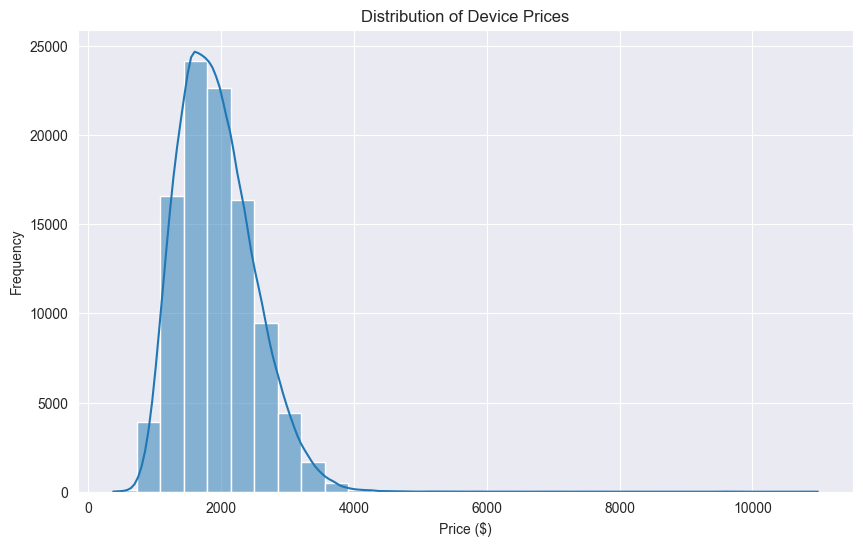

Mean Price: $1928.76
Median Price: $1863.99

The distribution is right-skewed because the mean ($1928.76) is greater than the median ($1863.99).
This indicates that there are some expensive devices pulling the average up, with the tail extending to the right.


In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df.to_pandas(), x='price', bins=30, kde=True)
plt.title('Distribution of Device Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

price_mean = df.select(pl.col('price').mean()).item()
price_median = df.select(pl.col('price').median()).item()

print(f"Mean Price: ${price_mean:.2f}")
print(f"Median Price: ${price_median:.2f}")
print(
    f"\nThe distribution is right-skewed because the mean (${price_mean:.2f}) is greater than the median (${price_median:.2f}).")
print(
    "This indicates that there are some expensive devices pulling the average up, with the tail extending to the right.")


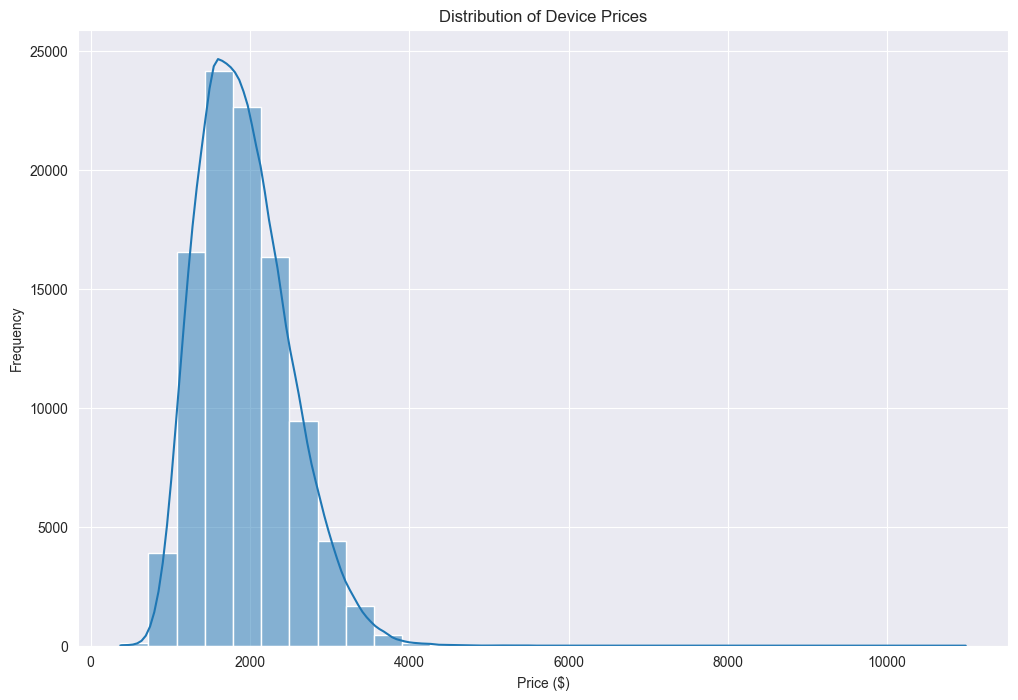

Mean Price: $1928.76
Median Price: $1863.99

The distribution is right-skewed because the mean ($1928.76) is greater than the median ($1863.99).
This indicates that there are some expensive devices pulling the average up, with the tail extending to the right.


In [18]:
plt.figure(figsize=(12, 8))
sns.histplot(df.to_pandas(), x='price', bins=30, kde=True)
plt.title('Distribution of Device Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

price_mean = df.select(pl.col('price').mean()).item()
price_median = df.select(pl.col('price').median()).item()

print(f"Mean Price: ${price_mean:.2f}")
print(f"Median Price: ${price_median:.2f}")
print(
    f"\nThe distribution is right-skewed because the mean (${price_mean:.2f}) is greater than the median (${price_median:.2f}).")
print(
    "This indicates that there are some expensive devices pulling the average up, with the tail extending to the right.")

In [19]:
top_5_brand = df.select(
    pl.col('brand')
).group_by(
    'brand'
).len().sort(
    by='len', descending=True
).head(5)

top_5_brand

brand,len
str,u32
"""Lenovo""",15992
"""HP""",14114
"""Dell""",14005
"""Apple""",11915
"""ASUS""",10159


In [20]:
fig = px.bar(
    top_5_brand,
    x='brand',
    y='len'
)

fig.update_layout(
    title='Top 5 Brands by Number of Devices',
    width=800,
    height=600
)

fig

In [22]:
os_counting = df.select(
    pl.col('os')
).group_by(
    'os'
).len().sort(
    by='len', descending=True
)
os_counting

os,len
str,u32
"""Windows""",71817
"""macOS""",18207
"""Linux""",6109
"""ChromeOS""",3867


In [25]:
fig = px.bar(
    data_frame=os_counting
,
    x='os',
    y='len'
)

fig.update_layout(
    width=800,
    height=600,
)

fig.show()

In [31]:
ram_price = df.select(
    pl.col('ram_gb', 'price')
)

ram_price.corr()

ram_gb,price
f64,f64
1.0,0.758654
0.758654,1.0


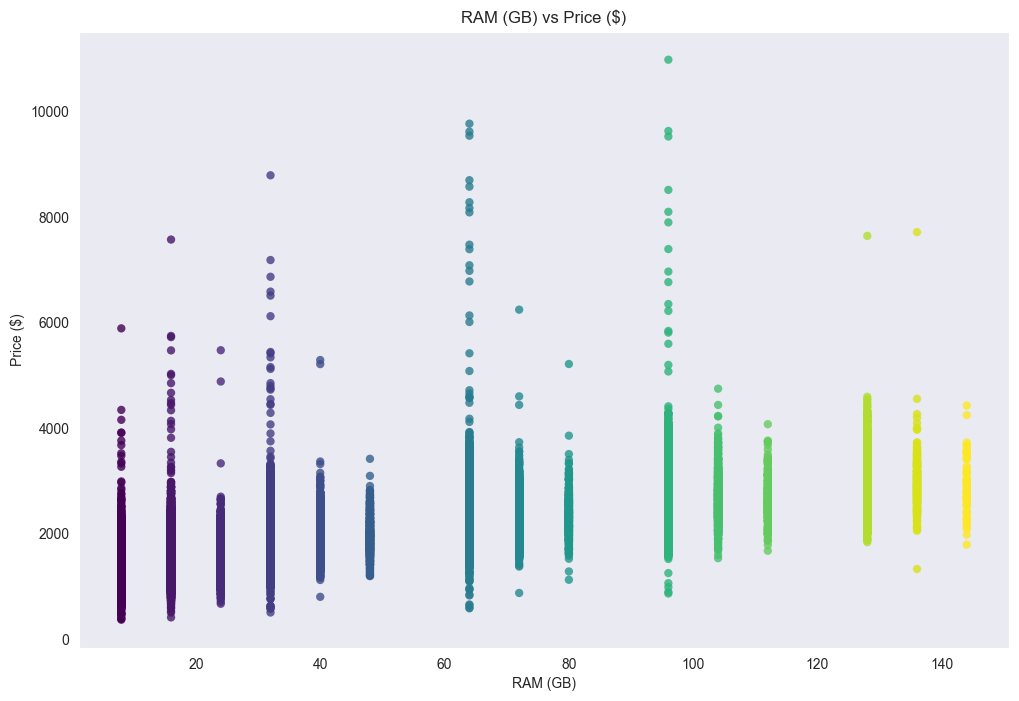

In [36]:
plt.figure(figsize=(12, 8))
plt.scatter(
    ram_price['ram_gb'],  # X-axis: RAM (GB)
    ram_price['price'],  # Y-axis: Price ($)
    c=ram_price['ram_gb'],
    cmap='viridis',
    alpha=0.8,
    edgecolors='none'
)
plt.title('RAM (GB) vs Price ($)')
plt.xlabel('RAM (GB)')
plt.ylabel('Price ($)')
plt.grid(False)

plt.show()


In [43]:
df.select(
    pl.col('device_type', 'price')
).filter(
    (pl.col('device_type') == 'Desktop') |
    (pl.col('device_type') == 'Laptop')
).group_by(
    pl.col('device_type')
).agg(
    pl.mean('price').alias('price_mean'),
    pl.median('price').alias('price_median')
)

device_type,price_mean,price_median
str,f64,f64
"""Desktop""",1819.545284,1767.99
"""Laptop""",2002.05136,1934.99
